<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="250" align="center">

**PROCESAMIENTO DE LENGUAJE NATURAL**

*DESAFÍO Nº1 - BOTS - JUAN I. MUNAR*

**1. BOT DNN + Spacy (PyTorch)**

1.1. Instalo e importo dependencias, obtengo un diccionario

In [ ]:
# Librerías varias
import json
import string
import random
import numpy as np

# Ploteo
import matplotlib.pyplot as plt
import seaborn as sns

# Torch
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Obtención resultados
import torchsummary

# Torch helpers
import os
import platform
if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py


In [ ]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

# SpaCy armó un wrapper para los pipelines y modelos de Stanza (librería de NLP de Stanford)
import stanza
import spacy_stanza

# Descargo el diccionario en español y armo el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

INFO:stanza:Downloading default packages for language: es (Spanish)...
INFO:stanza:File exists: /root/stanza_resources/es/default.zip.
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Don

1.2. Preprocesamiento del texto

In [ ]:
# Librerías
import re
import unicodedata

# Función de preprocesamiento
def preprocess_clean_text(text):
    # Pasar todo el texto a minúsculas
    text = text.lower()
    # Sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]'
    # Quitar números
    text = re.sub(pattern, '', text)
    # Quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

1.3. Diccionario de entrada

In [ ]:
# Diccionario de entrada en formato json con posibles preguntas y respuestas
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?", "¿Cómo va?", "¿Cómo andas?", "Buen día"],
              "responses": ["Hola, buen día, se ha comunicado con un centro de denuncias de bajo presupuesto. \n ¿Cuál es el delito que desea denunciar?"],
             },
             {"tag": "estupefacientes",
              "patterns": ["Están vendiendo drogas", "venden cocaína",
                           "venden fafafa", "venden marihuana",
                           "venden extásis", "venden pastillas", "venden LSD",
                           "hay dealers", "narcotráfico"],
              "responses": ["Dígame la dirección"]
             },
             {"tag": "direccion",
              "patterns": ["la dirección es calle", "la ubicación es calle", "el lugar queda en"],
              "responses": ["Envío un efectivos al lugar. ¿Algo más en que lo pueda ayudar?"]
             },
            {"tag": "homicidio",
              "patterns": ["hubo un asesinato", "hubo un homicidio",
                           "mataron a una persona", "mataron a alguien",
                           "le dispararon a alguien", "le dispararon a mi"],
              "responses": ["Por favor póngase a resguardo, Dígame la dirección"]
             },
            {"tag": "robo",
              "patterns": ["hubo un robo", "hubo un hurto", "hay un ladrón",
                           "hay un chorro", "me robaron", "le robaron"],
              "responses": ["Si pudo identificar al ladrón, por favor dirijase a la comisaria más cercana para realizar un identikit. \n ¿Algo más en que lo pueda ayudar? "]
             },
            {"tag": "heridos",
              "patterns": [ "hay un herido", "hay un hombre lastimado",
                           "hay una persona grave", "hay un quemado",
                           "fue apuñalada", "estoy herido", "estoy lastimado"],
              "responses": ["Hay una ambulancia en camino. ¿Algo más en que lo pueda ayudar?"]
             },
             {"tag": "fuego",
              "patterns": [ "hay fuego", "hay un incendio", "se está quemando"],
              "responses": ["Muy interesante, lo anotaré en mi máquina de escribir invisible"]
             },
             {"tag": "despedida",
              "patterns": ["Adios", "Chau", "Hasta luego", "Bye", "ok", "si", "no"],
              "responses": ["Gracias, adios"]
             }
]}

1.4. Preprocesamiento y armado del dataset

In [ ]:
# Datos que necesitaremos, las palabras o vocabilario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern))
        # lematizar los tokens
        for token in tokens:
            words.append(token.lemma_)

        doc_X.append(pattern)
        doc_y.append(intent["tag"])

    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

<ipython-input-5-de38f27299c1>:15: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  tokens = nlp(preprocess_clean_text(pattern))
<ipython-input-5-de38f27299c1>:15: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['se', 'e', 'esta', 'quemando']
Entities: []
  tokens = nlp(preprocess_clean_text(pattern))


In [ ]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['a', 'adios', 'alguien', 'andar', 'apunalar', 'asesinato', 'buen', 'bye', 'calle', 'chau', 'chorro', 'cocaina', 'como', 'dealers', 'dia', 'direccion', 'disparar', 'droga', 'e', 'el', 'en', 'estar', 'este', 'extasis', 'fafafa', 'fuego', 'grave', 'haber', 'hasta', 'herido', 'holar', 'hombre', 'homicidio', 'hurto', 'incendio', 'ir', 'ladron', 'lastimado', 'lsd', 'luego', 'lugar', 'marihuana', 'matar', 'mi', 'narcotrafico', 'no', 'ok', 'pastilla', 'persona', 'que', 'quedar', 'quemar', 'robar', 'robo', 'ser', 'si', 'tal', 'ubicacion', 'uno', 'vender', 'yo', 'él']
classes: ['bienvenida', 'despedida', 'direccion', 'estupefacientes', 'fuego', 'heridos', 'homicidio', 'robo']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¿Cómo va?', '¿Cómo andas?', 'Buen día', 'Están vendiendo drogas', 'venden cocaína', 'venden fafafa', 'venden marihuana', 'venden extásis', 'venden pastillas', 'venden LSD', 'hay dealers', 'narcotráfico', 'la dirección es calle', 'la ubicación es calle', 'el lugar queda e

In [ ]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)

    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] y: [1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

<ipython-input-7-84adf1c05755>:10: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  tokens = nlp(preprocess_clean_text(doc))
<ipython-input-7-84adf1c05755>:10: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['se', 'e', 'esta', 'quemando']
Entities: []
  tokens = nlp(preprocess_clean_text(doc))


X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] y: [0, 0, 0, 0, 1, 0, 0, 0]
X: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores.
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.float32))
        # las loss function esperan la salida float
        self.y = torch.from_numpy(y.astype(np.float32))

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(train_X, train_y)

input_dim = data_set.x.shape[1]
print("Input dim", input_dim)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

Input dim 62
Output dim 8


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(data_set, batch_size=32, shuffle=False)

In [ ]:
class Model1(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=128) # fully connected layer
        self.fc2 = nn.Linear(in_features=128, out_features=64) # fully connected layer
        self.fc3 = nn.Linear(in_features=64, out_features=output_dim) # fully connected layer

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.softmax(self.fc3(out))
        return out

# Crear el modelo basado en la arquitectura definida
model1 = Model1(input_dim=input_dim, output_dim=output_dim)
# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

torchsummary.summary(model1, input_size=(1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           8,064
              ReLU-2               [-1, 1, 128]               0
           Dropout-3               [-1, 1, 128]               0
            Linear-4                [-1, 1, 64]           8,256
              ReLU-5                [-1, 1, 64]               0
           Dropout-6                [-1, 1, 64]               0
            Linear-7                 [-1, 1, 8]             520
           Softmax-8                 [-1, 1, 8]               0
Total params: 16,840
Trainable params: 16,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


In [ ]:
from torch_helpers import categorical_acc

def train(model, train_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []

    ## Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error y accuracy para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
    }

    return history

In [ ]:
history1 = train(model1,
                train_loader,
                model1_optimizer,
                model1_criterion,
                epochs=300
                )

Epoch: 1/300 - Train loss 2.082 - Train accuracy 0.047
Epoch: 2/300 - Train loss 2.080 - Train accuracy 0.160
Epoch: 3/300 - Train loss 2.077 - Train accuracy 0.192
Epoch: 4/300 - Train loss 2.079 - Train accuracy 0.080
Epoch: 5/300 - Train loss 2.077 - Train accuracy 0.160
Epoch: 6/300 - Train loss 2.075 - Train accuracy 0.258
Epoch: 7/300 - Train loss 2.075 - Train accuracy 0.327
Epoch: 8/300 - Train loss 2.076 - Train accuracy 0.241
Epoch: 9/300 - Train loss 2.075 - Train accuracy 0.263
Epoch: 10/300 - Train loss 2.074 - Train accuracy 0.241
Epoch: 11/300 - Train loss 2.071 - Train accuracy 0.325
Epoch: 12/300 - Train loss 2.071 - Train accuracy 0.390
Epoch: 13/300 - Train loss 2.069 - Train accuracy 0.309
Epoch: 14/300 - Train loss 2.069 - Train accuracy 0.390
Epoch: 15/300 - Train loss 2.066 - Train accuracy 0.327
Epoch: 16/300 - Train loss 2.066 - Train accuracy 0.358
Epoch: 17/300 - Train loss 2.062 - Train accuracy 0.421
Epoch: 18/300 - Train loss 2.058 - Train accuracy 0.343
E

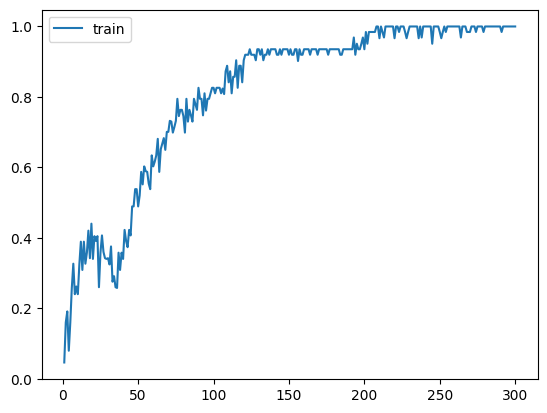

In [ ]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
plt.show()

1.6. Test validación

In [ ]:
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def bag_of_words(text, vocab):
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens:
        for idx, word in enumerate(vocab):
            if word == w:
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

def pred_class(text, vocab, labels):
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        x = torch.from_numpy(np.array([bow]).astype(np.float32))
        result = model1(x)[0].detach().numpy()
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)

        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents:
        if i["tag"] == tag:
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [ ]:
message = "Hola buenos dias"
intents = pred_class(message, words, classes)
if len(intents) > 0:
    result = get_response(intents, dataset)
    print(result)

BOT: Hola, buen día, se ha comunicado con un centro de denuncias de bajo presupuesto. 
 ¿Cuál es el delito que desea denunciar?


In [ ]:
while True:
    message = input("")
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else:
        print("Reformule por favor")

BOT: Hola, buen día, se ha comunicado con un centro de denuncias de bajo presupuesto. 
 ¿Cuál es el delito que desea denunciar?
BOT: Por favor póngase a resguardo, Dígame la dirección
BOT: Envío un efectivos al lugar. ¿Algo más en que lo pueda ayudar?
BOT: Si pudo identificar al ladrón, por favor dirijase a la comisaria más cercana para realizar un identikit. 
 ¿Algo más en que lo pueda ayudar? 
BOT: Dígame la dirección
BOT: Envío un efectivos al lugar. ¿Algo más en que lo pueda ayudar?
BOT: Muy interesante, lo anotaré en mi máquina de escribir invisible
BOT: Gracias, adios


1.7. Conclusiones

El bot es muy limitado en la comprensión de los inputs del usuario. Las preguntas y el texto debe ser muy guionado caso contrario se pierde fácilmente. Aumentar el entrenamiento o profundizar la arquitectura no parecen mejorar sensiblemente los resultados, o incluso los empeoran.

**2. BOT TF-IDF + Similitud Coseno**

2.1. Importo e instalo librerías

In [ ]:
import spacy
!python -m spacy download es_core_news_sm
import es_core_news_sm
import json
import string
import random
import numpy as np

2023-11-18 21:55:58.838038: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 21:55:58.838098: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 21:55:58.838140: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 21:56:00.014618: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 2.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


2.2 Con Beautiful Soup obtengo el texto de un artículo de Wikipedia

In [ ]:
# Para leer y parsear el texto en HTML
import bs4 as bs
import urllib.request

raw_html = urllib.request.urlopen('https://es.wikipedia.org/wiki/Monstera')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text

article_text = article_text.lower()

2.3. Proceso el texto para obtener un corpus y su lematización. Utilizo la librería SpaCy para lematizar en español.

In [ ]:
# Obtengo un corpus y su lematización
import re
import unicodedata

# Primera función de procesamiento de texto
def preprocess_clean_text(text):
    # Pasar todo el texto a minúsculas
    text = text.lower()
    # Sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]'
    # Quitar números
    text = re.sub(pattern, '', text)
    return text

# Segunda función de procesamiento de texto
def preprocess_clean_text_final(text):
    # Eliminar caracteres y espacios innecesarios
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

# Función de procesamiento
def procesamiento(texto):
  # Operaciones con RegEx
  text = re.sub(r'\[[0-9]*\]', ' ', texto)
  text = re.sub(r'\s+', ' ', text)

  # Función de preprocesamiento
  text = preprocess_clean_text(text)

  # Carga del pipeline de procesamiento en español (es)
  nlp = spacy.load('es_core_news_sm')

  # Proceso el texto
  doc = nlp(text)

  # Obtengo el corpus
  corpus = [str(oracion) for oracion in doc.sents]

  # Filtro las stop-words del corpus
  corpus_procesado = []
  for frase in corpus:
      doc_frase = nlp(frase)
      palabras_sin_stopwords = [token.text for token in doc_frase if not token.is_stop]
      frase_procesada = ' '.join(palabras_sin_stopwords)
      corpus_procesado.append(frase_procesada)

  # El corpus lematizado es:
  corpus_lemma = []
  for frase in corpus_procesado:
    doc_frase = nlp(frase)
    frase_lematizada = ' '.join([token.lemma_ for token in doc_frase])
    corpus_lemma.append(frase_lematizada)

  # Vuelvo a procesar el texto
  corpus_lemma_final = []
  for frase in corpus_lemma:
    frase_limpia = preprocess_clean_text_final(frase)
    corpus_lemma_final.append(frase_limpia)

  return corpus, corpus_lemma_final

In [ ]:
# Aplicamos
corpus, corpus_lemma = procesamiento(article_text)

2.4. Introduzco un input del usuario, lo proceso y obtengo una respuesta

In [ ]:
# Aplico la misma función para el input del usuario
input_usuario = input("")
corpus_usuario, lemma_usuario = procesamiento(input_usuario)

# Uno el input del usuario al corpus para hacer la similitud coseno
corpus_lemma.append(lemma_usuario[0])

# Planteo la similitud coseno entre vectores TF-IDF
def similitud_documento(corpus, indice):
  corpus = np.array(corpus)

  # Obtengo listas de términos y términos que las integran
  listas_terminos = np.char.split(corpus)
  array_terminos = np.concatenate([np.array(lista) for lista in listas_terminos])
  terminos, count = np.unique(array_terminos, return_counts=True)

  # Obtengo el One Hot Encoding
  matriz_OHE = np.array([np.isin(terminos, listas_terminos[i]).astype(int) for i in range(listas_terminos.size)])

  # Broadcasting
  IDF = np.log10(corpus.size / np.sum(matriz_OHE, axis=0))

  # Factor TF
  lista_vectores = []
  for i in range(listas_terminos.size):
    vector = np.zeros(len(terminos), dtype=int)
    for palabra in listas_terminos[i]:
      coincidencias = (terminos == palabra)
      vector = vector + coincidencias
    lista_vectores.append(vector)

  # Convierto en array
  TF = np.array(lista_vectores)

  # Obtengo la matriz
  matriz_TF_IDF = TF * IDF

  # Obtengo el vector de producto punto
  dot = np.sum(matriz_TF_IDF[indice]* matriz_TF_IDF, axis=1)

  # Norma del vector
  norma_vector = np.linalg.norm(matriz_TF_IDF[indice])

  # Vector de normas
  norma_matriz = np.linalg.norm(matriz_TF_IDF, axis = 1)

  # Similitud coseno
  vector_similitud = dot / (norma_vector * norma_matriz)

  # Ordeno por similitud coseno, el "-" ordena de mayor a menor
  orden = np.argsort(- vector_similitud)

  # Obtengo los documentos ordenados
  corpus_ordenado = corpus[orden]

  return orden, corpus_ordenado

# Aplico la función
orden, corpus_ordenado = similitud_documento(corpus_lemma, -1)

# Obtengo mi respuesta
print(corpus[orden[1]])

De dónde es  originaria la monstera?
es originario de mexico y america tropical.  


2.5. Conclusiones

El segundo BOT parece mucho más flexible frente a las preguntas del usuario. El principal problema que encuentra es la falta de desarrollo de la lematización en español.